Henry Ginder

Astr425

Final Project

In [2]:
import astropy.cosmology as cosmo
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd
import theano
import theano.tensor as t
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
names = ['Redshift', 'Supernova Distance', 'Distance Error']

data = pd.read_csv('SN.data', comment = '#', names=names, header = None)

In [4]:
data

,Redshift,Supernova Distance,Distance Error
0,0.336886,1480.919735,73.014139
1,0.186857,750.610735,37.321367
2,0.442316,2088.225990,100.775470
3,0.388877,1789.298150,86.443520
4,0.181246,768.578074,36.080277
...,...,...,...
495,0.140422,554.107761,27.264601
496,0.919220,5040.818899,249.077286
497,0.429994,1984.276772,97.424628
498,0.239588,1014.942769,49.325590


In [5]:
z = data['Redshift']
d = data['Supernova Distance']
err = data['Distance Error']

z

0      0.336886
1      0.186857
2      0.442316
3      0.388877
4      0.181246
         ...   
495    0.140422
496    0.919220
497    0.429994
498    0.239588
499    0.313845
Name: Redshift, Length: 500, dtype: float64

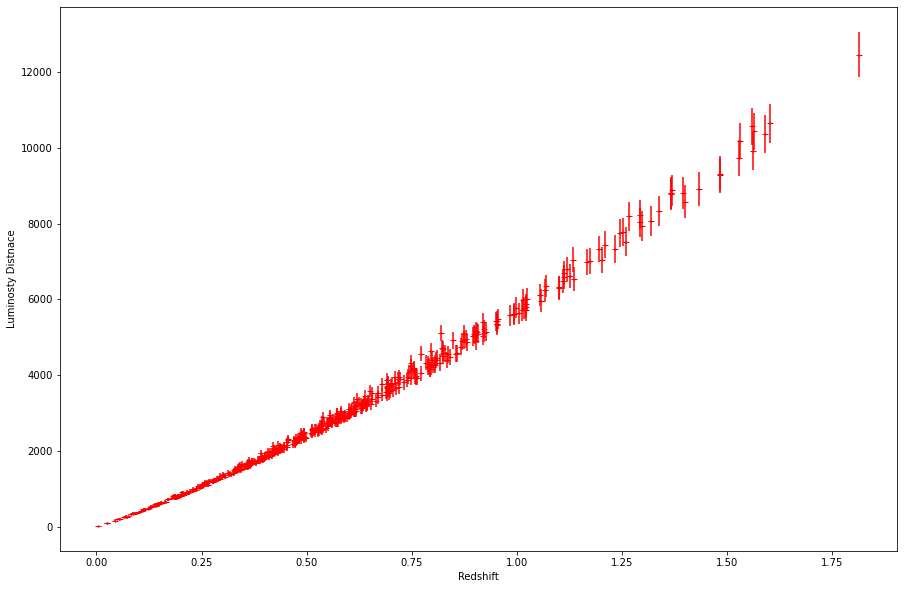

In [6]:
plt.figure(figsize=(15,10))
plt.scatter(z, d, s=1.5, color='r')
plt.errorbar(z, d, err, fmt='_', c = 'r')
plt.xlabel('Redshift')
plt.ylabel('Luminosty Distnace');

a) Above is the graph of our supernova data when plotting the redshift vs distance. This relation is well known and these data do look right, because there is a correlation between redshift and distance. Notice how the error bars are much smaller at smaller redshifts than at much larger redshifts. It makes sense because objects at higher redshifts are generally further away, meaning there are way more ways that our observations can get skewed, compared to observing a supernova in our own galaxy.

In [25]:
@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar,t.dscalar], otypes=[t.dscalar])

def universe(O_m, O_del, H_0, z):

    model = cosmo.wCDM(H0 = H_0, Om0 = O_m, Ode0=O_del)

    distance = model.luminosity_distance(z)

    return distance

The next cell was running completely fine until I was messing around with one of the parameters (per David's suggestion, I don't blame him though haha ;) ). Once I got an error and went back to my first (already succesful) method I started getting older error messages (that I had been dealing with earlier). Only issue is that now, somehow, I can't troubleshoot this old error messages like I did earlier (it required me to update some of my packages, and now they are all updated but still failing me). AKA something broke in my notebook :( I've been restarting the kernel/computer over and over and I am positive this is the code I used earlier that was working perfect, I have even tried running this in a different notebook.... I have no idea why. When I look online, most of the error messages I am getting pertain specifically to Mac OS.

To say I am frustrated is an understatement. I can't finish the assignment all the way through without access to the model. I am just going to make do and turn in what I can, I don't expect to be able to make the corner plots. I understand this will affect my grade negativley, however it isn't the end of the world since I have done mostly well on the other work in this class and don't *need* to do particularly well in this class to graduate or anything.


As far as the change that caused this, it was when I changed the first line in the cell above from:



@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar,t.dscalar], otypes=[t.dscalar])

to 

@theano.compile.ops.as_op(itypes=[t.dscalar, t.dscalar, t.dscalar,t.vector], otypes=[t.vector])



where the only changes were the last itype in the list and the otypes both switching to type vector.

In [26]:
with pm.Model():
    O_m = pm.Uniform('O_m', 0, 1)
    O_del = pm.Uniform('O_del', 0, 1)
    H_0 = pm.Uniform('H_0', 50, 90)
    z = pm.Uniform('redshift', 0, 2)

    distance = pm.Normal('distance', mu=universe(O_m, O_del, H_0, z), sd=data['Distance Error'], observed=data['Supernova Distance'])

    step = pm.Metropolis()
    traces = pm.sample(draws=25000, tune=1000, step=step, chains=4)

INFO (theano.gof.compilelock): Refreshing lock /Users/henryginder/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock



You can find the C code in this temporary file: /var/folders/jy/7s8kjw015fx7jvdlydr1dm8c0000gn/T/theano_compilation_error_8xzucnpd


Exception: ("Compilation failed (return status=1): In file included from /Users/henryginder/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/tmptcjbl03m/mod.cpp:1:. In file included from /Users/henryginder/miniconda3/include/python3.7m/Python.h:25:. /Users/henryginder/miniconda3/bin/../include/c++/v1/stdio.h:107:15: fatal error: 'stdio.h' file not found. #include_next <stdio.h>.               ^~~~~~~~~. 1 error generated.. ", '[Elemwise{add,no_inplace}(TensorConstant{1.0}, TensorConstant{0.0})]')

In [15]:
def traces_to_pandas(traces, burnin):
    varnames = [ var for var in traces.varnames if not var.endswith("_interval__") ]
    cols = { var: traces[var, :burnin] for var in varnames }
    return pd.DataFrame(cols)

In [16]:
table = traces_to_pandas(traces, 1000)
table

np.mean(table['H_0'])

72.08203853560278

This is remarkably close to the *actual, approximated* Hubble constant (in fact it could be perfect since we do not know precisely the value of the Hubble constant and this falls well within the range of acceptable, usable values). Way to go MCMC!

In [17]:
pm.summary(traces)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
O_m,0.501,0.289,0.023,0.960,0.002,0.001,22602.0,22602.0,21235.0,22445.0,1.0
O_del,0.502,0.288,0.060,0.999,0.002,0.001,21736.0,21483.0,20093.0,22512.0,1.0
H_0,72.082,11.348,53.318,89.993,0.121,0.085,8852.0,8852.0,8784.0,16303.0,1.0
redshift,0.001,0.000,0.000,0.001,0.000,0.000,8392.0,8392.0,8332.0,13951.0,1.0


The table above shows us the 'expexted' value as well as the error in those values. For example, the expected value of $\Omega_m$ is 0.501, but there is an error, shown by the standard deviation in $\Omega_m$ as 0.289. Notice the redshift approaching 0, as well as all the r_hat values equalling 1.

In [28]:
test = pm.summary(traces) #same as above

test['mean']['O_m'] #use in plot to test goodness of fit

0.501

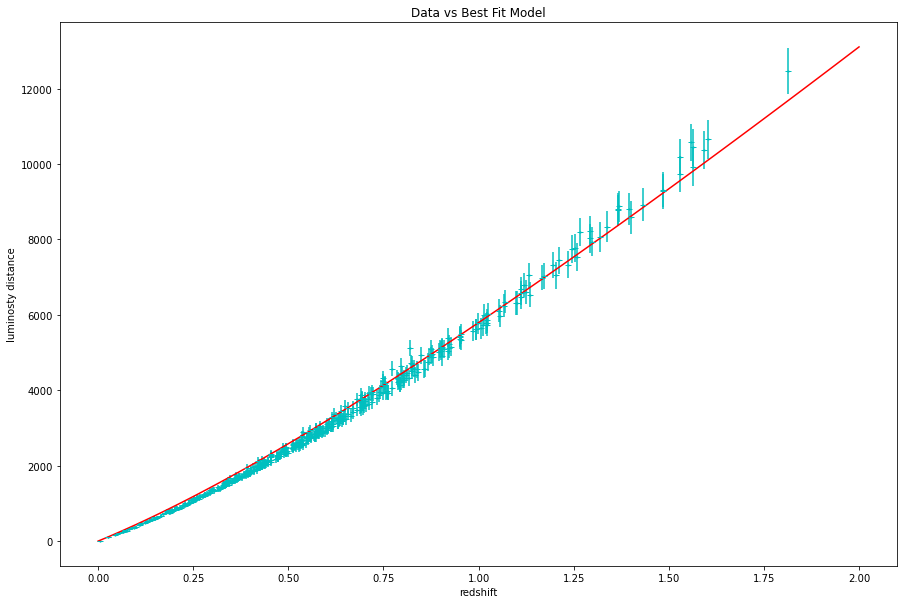

In [40]:
z = data['Redshift']
d = data['Supernova Distance']
err = data['Distance Error']

z = theano.shared(np.asarray(data['Redshift']).astype("float64"))

check = cosmo.wCDM(test['mean']['H_0'], test['mean']['O_m'], test['mean']['O_del'])

fig, ax = plt.subplots(1,1, figsize = (15,10))

ax.scatter(z, d, s=1.5, color='c')
ax.errorbar(z, d, err, fmt='_', c = 'c')
ax.set_xlabel('redshift')
ax.set_ylabel('luminosty distance')
ax.set_title('Data vs Best Fit Model')

ax.plot(check_z, check.luminosity_distance(check_z), c = 'r');

The above visualization shows the the raw data vs our cosmological model we've created. The data fit here seems to be just a bit off, but it isn't terrible. It appears to be slightly too high at small redshifts and slightly too low at larger redshifts. 

My attempts to better this model led to it's inevitable, untimely death